In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

In [2]:
mobile = pd.read_csv("gs://devdutt_bucket/amazon_reviews_us_Mobile_Electronics_v1.tsv",
                    sep = '\t',
                    on_bad_lines='skip',
                    usecols = ['marketplace','product_category', 'star_rating', 'review_headline', 'review_body'])

In [3]:
mobile.tail()

,marketplace,product_category,star_rating,review_headline,review_body
104849,US,Mobile_Electronics,5.0,The Cat Barf is Gone!,"I've been looking for a while for the \\""purr\..."
104850,US,Mobile_Electronics,5.0,Well worth [it],We live in an apartment with hardwood floors a...
104851,US,Mobile_Electronics,5.0,Its a Time saver!!!,I received this for a birthday present and Its...
104852,US,Mobile_Electronics,5.0,Got Stains?,I got the Dirt Devil Spot Scrubber for a gift ...
104853,US,Mobile_Electronics,4.0,no smell has to mean it is getting the job don...,I purchased this about three weeks ago along w...


In [4]:
mobile.shape

(104854, 5)

In [5]:
mobile.dtypes

marketplace          object
product_category     object
star_rating         float64
review_headline      object
review_body          object
dtype: object

In [6]:
mobile['star_rating'].value_counts(dropna=False)

5.0    52199
4.0    18063
1.0    17572
3.0     9720
2.0     7298
NaN        2
Name: star_rating, dtype: int64

In [7]:
mobile.dropna(subset=['star_rating', 'review_headline', 'review_body'], inplace = True)

In [8]:
mobile['marketplace'].value_counts(dropna=False)

US    104849
Name: marketplace, dtype: int64

In [9]:
mobile['product_category'].value_counts(dropna=False)

Mobile_Electronics    104849
Name: product_category, dtype: int64

In [10]:
mobile['star_rating'] = mobile['star_rating'].astype(int)

In [11]:
mobile['star_rating'].value_counts(dropna=False)

5    52197
4    18063
1    17572
3     9719
2     7298
Name: star_rating, dtype: int64

In [12]:
# mobile = mobile[(mobile['star_rating'] == 1) | (mobile['star_rating'] == 5)]

In [13]:
mobile['star_rating'].value_counts(dropna=False)

5    52197
4    18063
1    17572
3     9719
2     7298
Name: star_rating, dtype: int64

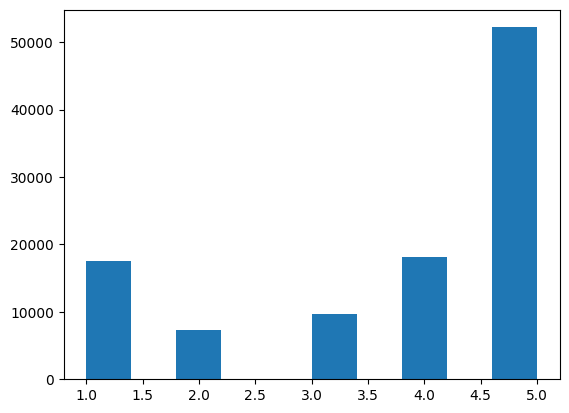

In [14]:
plt.hist(mobile['star_rating'])
plt.show()

In [15]:
mobile['sentiment'] = mobile['star_rating'].map({1:-1, 2:0,3:0,4:0, 5:1})

In [16]:
mobile['sentiment'].value_counts()

 1    52197
 0    35080
-1    17572
Name: sentiment, dtype: int64

In [17]:
mobile['text'] = mobile['review_headline'] + " " + mobile['review_body']

In [18]:
mobile = mobile[['text', 'sentiment']]

In [21]:
mobile.head()

,text,sentiment
0,Very Happy! As advertised. Everything works pe...,1
1,five star it's great,1
2,great cables These work great and fit my life ...,1
3,Work very well but couldn't get used to not he...,0
4,Cameras has battery issues Be careful with the...,0


In [24]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

# pd.reset_option('^display.', silent=True)

In [29]:
!pip install pandarallel

  Using cached pandarallel-1.6.5-py3-none-any.whl
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)


In [30]:
#import pandarallel

In [31]:
from pandarallel import pandarallel
import multiprocessing
num_processors = multiprocessing.cpu_count()
workers = num_processors-1
print(f'Available CPUs: {num_processors}')

Available CPUs: 8


In [32]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [33]:
%%time

mobile['text_length'] = mobile['text'].parallel_apply(lambda x: len(x.split()))

CPU times: user 97 ms, sys: 195 ms, total: 292 ms
Wall time: 439 ms


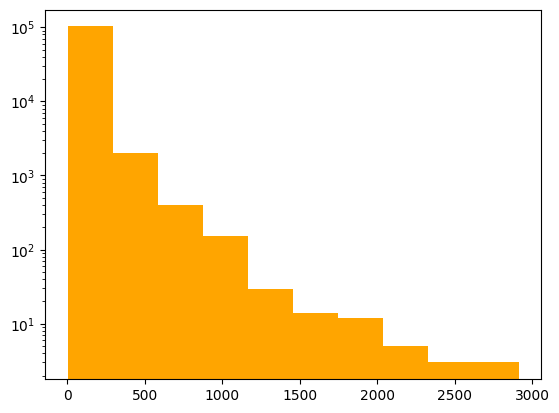

In [34]:
plt.hist(mobile['text_length'], color = "orange", log=True)

plt.show()

In [39]:
mobile.to_csv('mobile__multi_sent.csv', index=False)

In [40]:
# define X and y
X = mobile['text']
y = mobile['sentiment']

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (104849,)
y Shape: (104849,)


In [41]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(f"Training records: \n X_train: {X_train.shape} \n y_train: {y_train.shape}")
print(f"Testing records: \n  X_test: {X_test.shape} \n y_test: {y_test.shape}")

Training records: 
 X_train: (78636,) 
 y_train: (78636,)
Testing records: 
  X_test: (26213,) 
 y_test: (26213,)


In [42]:
vect = CountVectorizer(stop_words='english')

### Base Model (Naive Bayes)

In [43]:
# instantiate a Multinomial Naive Bayes model
nb = MultinomialNB()

In [44]:
%time

nb.fit(vect.fit_transform(X_train), y_train)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.7 µs


MultinomialNB()

In [45]:
# make class predictions
y_pred = nb.predict(vect.transform(X_test))

In [46]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {metrics.accuracy_score(y_test, y_pred) * 100:.1f}%")

Test Accuracy: 72.1%


In [47]:
# calculate precision and recall
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.73      0.73      0.73      4390
           0       0.64      0.52      0.57      8850
           1       0.76      0.86      0.81     12973

    accuracy                           0.72     26213
   macro avg       0.71      0.70      0.70     26213
weighted avg       0.71      0.72      0.71     26213



In [48]:
# calculate the confusion matrix
print(metrics.confusion_matrix(y_test, y_pred))

[[ 3214   963   213]
 [  978  4596  3276]
 [  219  1656 11098]]
